# Interpolation Methods

Due to the discrete (and sometimes sparse) nature of experiments and observations, data taking procedures will always produce discrete data as well. Even, as we have seen before, information only can be discretely presented into a computer due to the binary representation. However, when we are dealing with physical models, continuous and smooth properties are of course preferred. Interpolation techniques allow then to recover a continuous field (intermediate values) from sparse datasets. Throughout this section we shall cover some of these interpolation methods.

---

__Homework__: https://classroom.github.com/a/SB94rDVJ

- - -
- [NumPy polynomials](#NumPy-Polynomials)
- [Linear Interpolation](#Linear-Interpolation)
    - [Steps](#Steps-LI)
    - [Example 1](#Example-1)
- [Lagrange Polynomial](#Lagrange-Polynomial)
    - [Derivation](#Derivation)
    - [Steps](#Steps-LP)
    - [Activity](#Activity-LP)
- [Divided Differences](#Divided-Differences)
    - [Example 2](#Example-2)
- [Hermite Interpolation](#Hermite-Interpolation)
    - [Derivation in terms of divided differences](#Derivation-in-terms-of-divided-differences)
    - [Example 3](#Example-3)
- - -

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from IPython.display import display, Markdown, Latex, Image 
import pandas as pd

In [0]:
from scipy import interpolate

In [0]:
import numpy as np
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
#from JSAnimation import IPython_display
from matplotlib import animation
from IPython.core.display import Image 

- - -

# NumPy Polynomials

In Numpy there is an implementation of Polynomials. The object is initialized giving the polynomial coefficients: 

In [6]:
p = np.poly1d([1, 2, -3])
print(p)

   2
1 x + 2 x - 3


By default is assigned the attribute `variable`

In [7]:
p.variable

'x'

which can be assigned at initialization 

In [8]:
q = np.poly1d([1, 2, -3],variable='t')
print(q)

   2
1 t + 2 t - 3


The object have in particular methods for <br/>
__Integration__:

In [10]:
p = np.poly1d([1, 2, -3])
print( p.integ() )

        3     2
0.3333 x + 1 x - 3 x


__Derivatives__

In [12]:
print( p.deriv() )

 
2 x + 2


__roots__:

In [13]:
print(p.roots)
display(Markdown( '$p({})$={}'.format(round(p.roots[0],1),
                                      p((p.roots[0] )  ) ) ) )

[-3.  1.]


$p(-3.0)$=1.7763568394002505e-15

 It is possible to define polynomial by given the list of roots and 

In [14]:
p=np.poly1d([-246.2,-40,40,246.2],r=True)
print(p)

   4             2
1 x - 6.221e+04 x + 9.698e+07


For further details check the official help:

In [0]:
np.poly1d?

__Activity__: 
1. Define a polynomial for the movement with uniform acceleration:
\begin{align}
x=x_0+v_0 (t-t_0)+\tfrac{1}{2} a (t-t_0)^2\,,
\end{align}
2. Use the definition to solve the problem of your "Taller"

<font color=red>Solution</font>

x1(t)=
   2
3 t
x2(t)=
   2
5 t - 90 t + 400


Text(0.5,1,'meeting time $t_{\\rm end}=$ 40 s; meeting point $x_{\\rm end}=$ 4800 m')

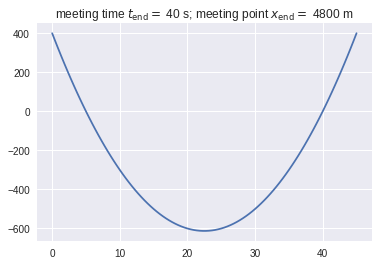

In [18]:
def x(x0,t0,v0,a):
    return np.poly1d( [0.5*a,v0-a*t0,x0-v0*t0+0.5*a*t0**2],
                     variable='t'  )
x1=x(0,0,0,6)
x2=x(0,10,10,10)
print('x1(t)=')
print(x1) 
print('x2(t)=')
print(x2)
t=np.linspace(0,45,100)
plt.plot(t,x2(t)-x1(t))
#plt.plot(t,(x2-x1)(t))
#plt.grid()
plt.title(r'meeting time $t_{\rm end}=$ %g s; meeting point $x_{\rm end}=$ %g m' 
          %(  (x2-x1).r[0]  ,  x2(  (x2-x1).r[0]  )   ))

%load polymua.py

(0, 200)

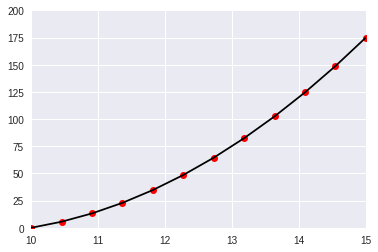

In [17]:
plt.plot(t,x2(t),'ro')
plt.plot(t,x2(t),'k-')
plt.xlim(10,15)
plt.ylim(0,200)

# Linear Interpolation

When we have a set of discrete points of the form $(x_i, y_i)$ for $1\leq i \leq N$, the most natural way to obtain (approximate) any intermediate value is assuming points connected by lines. Let's assume a set of points $(x_i, y_i)$ such that $y_i = f(x_i)$ for an unknown function $f(x)$, if we want to approximate the value $f(x)$ for $x_i\leq x \leq x_{i+1}$, we construct an equation of a line passing through $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$.

The linear equation is

$$y=mx+b$$

where

$$m=\frac{y_{i+1}-y_i}{x_{i+1}-x_i} $$

and $b$ is obtained by evaluating with either $(x_i,y_i)$ or $(x_{i+1},y_{i+1})$

$$y=\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x+b$$

$$b=y_i-\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x_i$$


\begin{align}
%$$  
f(x)\approx y = &\frac{y_{i+1}-y_i}{x_{i+1}-x_i}(x-x_i) + y_i \\
=&\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x+\left[y_i-\frac{y_{i+1}-y_i}{x_{i+1}-x_i}x_i\right] \\
%$$
\end{align}

and this can be applied for any $x$ such that $x_0\leq x \leq x_N$ and where it has been assumed an ordered set $\left\{x_i\right\}_i$.

## Steps LI

Once defined the mathematical basis behind linear interpolation, we proceed to establish the algorithmic steps for an implementation.

1. Establish the dataset you want to interpolate, i.e. you must provide a set of the form $(x_i,y_i)$.
2. Give the value $x$ where you want to approximate the value $f(x)$.
3. Find the interval $[x_i, x_{i+1}]$ in which $x$ is embedded.
4. Use the above expression in order to find $y=f(x)$.

## Example 1

Sample the function $f(x) = \sin(x)$ between $0$ and $10$ using $N=10$ intervals. Plot both, the interpolation and the original function.

In [0]:
x=np.linspace(0,6,10)

Interpolation:

In [0]:
interpolate.interp1d?

In [0]:
f=interpolate.interp1d( x,np.sin(x) )

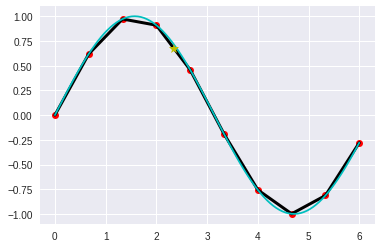

In [22]:
X=np.linspace(0,6,100)
plt.plot(x,f(x),'ro')
plt.plot(x,f(x),'k-',lw=3)
plt.plot(X,np.sin(X),'c-')
plt.plot(2.35,f(2.35),'y*',markersize=10)

In [23]:
f(2.35),np.sin(2.35)

(array(0.67198441), 0.7114733527908443)

the object `f` behaves like a function. For example. We can evaluate both the real and the interpolated function in $x_0=3$

In [24]:
np.sin(3)

0.1411200080598672

In [25]:
f(3)

array(0.13335233)

Text(0.5,1,'Linear interpolation of $\\sin(x)$')

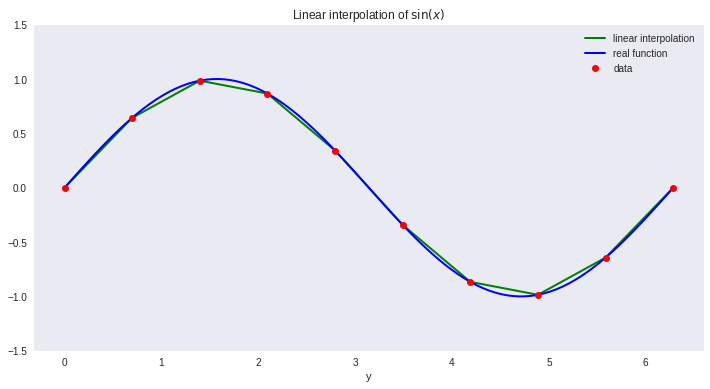

In [26]:
#Number of intervals for data 0 y 2*pi
Ndat = 10
Xn = np.linspace( 0, 2*np.pi, Ndat )
Yn = np.sin(Xn)

#Obtaining linear interpolation
Ninter = 100
x = np.linspace( 0, 2*np.pi, Ninter )
y = interpolate.interp1d( x, np.sin(x) )
f = np.sin(x)

#Plotting
plt.figure( figsize=(12,6) )
plt.plot( Xn, y(Xn), color="green", linewidth=2, label="linear interpolation" )
plt.plot( x, f, color="blue", linewidth=2, label="real function" )
plt.plot( Xn, Yn, "o", color="red", label="data" )

#Formatting
plt.legend()
plt.grid()
plt.xlabel( "x" )
plt.xlabel( "y" )
plt.ylim( (-1.5,1.5) )
plt.title( "Linear interpolation of $\sin(x)$" )

## <font color='red'>     **Activity** </font>

<font color='red'>    
    
Use the previous code and explore the behaviour of the Linear Interpolation algorithm when varying the number of data used.
</font>

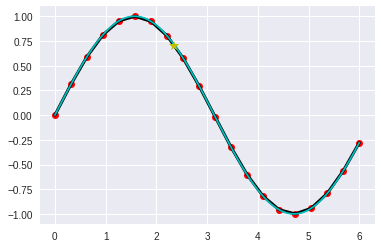

In [27]:
N=20
x=np.linspace(0,6,N)
f=interpolate.interp1d( x,np.sin(x) )
X=np.linspace(0,6,100)
plt.plot(x,f(x),'ro')
plt.plot(x,f(x),'k-',lw=3)
plt.plot(X,np.sin(X),'c-')
plt.plot(2.35,f(2.35),'y*',markersize=10)


- - -

## Example: 
Generate three points that do not lie upon a stright line, and try to make a manual interpolation with a polynomial of degree two.

In [0]:
df=pd.DataFrame({ 'X':[-2.4,3,21.3],
                  'Y':[-10.,8.,3.]
                 }  
                )

In [29]:
df

,X,Y
0,-2.4,-10.0
1,3.0,8.0
2,21.3,3.0


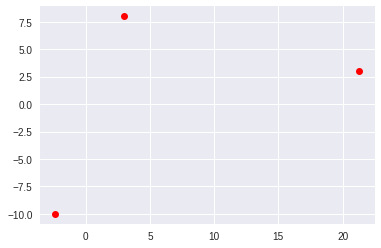

In [31]:
plt.plot(df.X,df.Y,'ro')
#plt.grid()

### Polynomial object in `numpy`
In `numpy` it is possible to define polynomials friom either its coefficients o its roots with `np.poly1d`

In [0]:
np.poly1d?

Define a two degree polynomial from its roots:

In [0]:
P=np.poly1d([1,22],True)

In [34]:
print(P)

   2
1 x - 23 x + 22


(-15, 20)

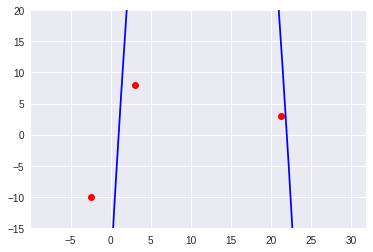

In [36]:
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,-P( x),'b-')
#plt.grid()
plt.ylim(-15,20)

HOMEWORK. Hacer la interpolación con la implementación en scipy buscando el grado óptimo del Polinomio

### Interpolation with `numpy`
`numpy` already include an interpolation function with polynomials called `np.polyfit`

In [0]:
np.polyfit?

In [0]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

In [38]:
print(np.poly1d(coeffs))

         2
-0.1522 x + 3.425 x - 0.9043


(-20, 20)

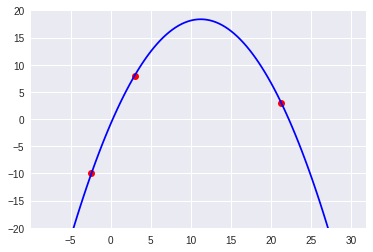

In [40]:
P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30,100)
plt.plot(x,P( x),'b-')
#plt.grid()
plt.ylim(-20,20)

In [41]:
P.variable

'x'

## Example: Least action
see [Least action](./solution_least_action.ipynb)

See also: [Least action (Google Drive)](https://drive.google.com/open?id=1UnKq382tUdb0SMiuxcitamPEcHzICujz)

In [0]:
np.poly1d?

# Lagrange Polynomial

Algebraic polynomials are very special functions as they have properties like differentiability (unlike linear interpolation) and continuity that make them useful for approximations like interpolation. A Polynomial is defined as a function given by the general expression:

$$P_n(x) = a_nx^n + a_{n-1}x^{n-1} + \cdots + a_1 x + a_0$$

where $n$ is the polynomial degree.

Another important property of polynomials is given by the [Weierstrass Approximation Theorem](http://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem), which states given a cotinuous function $f$ defined on a interval $[a,b]$, for all $\epsilon >0$, there exits a polynomial $P(x)$ such that

$$|f(x) - P(x)|<\epsilon\ \ \ \ \  \mbox{for all }\ x\ \mbox{ in }\ [a,b].$$

This theorem guarantees the existence of such a polynomial, however it is necessary to propose a scheme to build it.

In [0]:
df=pd.DataFrame({ 'X':[3,21.3],
                  'Y':[8.,3.]
                 }  
                )
df

,X,Y
0,3.0,8.0
1,21.3,3.0


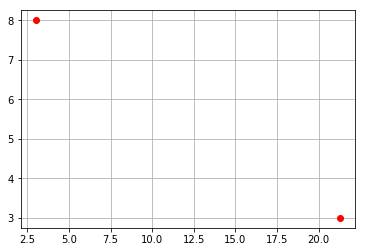

In [0]:
plt.plot(df.X,df.Y,'ro')
plt.grid()

Polinomio de interp. de grado <font "color=blue">0</font>

 
5.5


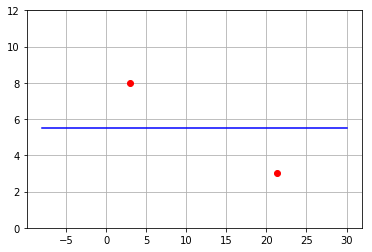

In [0]:
coeffs=np.polyfit(df.X,df.Y,deg=0)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

Polinomio de interp. de grado <font "color=blue">1</font>

 
-0.2732 x + 8.82


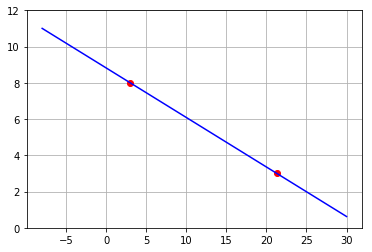

In [0]:
coeffs=np.polyfit(df.X,df.Y,deg=1)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

Polinomio de interp. de grado <font "color=blue">2</font>

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


           2
-0.008617 x - 0.06383 x + 8.269


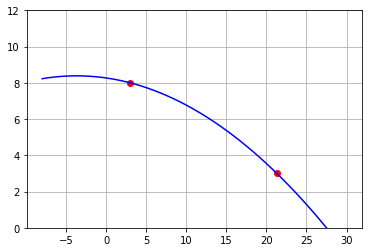

In [0]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

In [0]:
df=df.append({'X':10,'Y':6.5},ignore_index=True).sort_values('X')
df

,X,Y
0,3.0,8.0
2,10.0,6.5
1,21.3,3.0


           2
-0.005216 x - 0.1465 x + 8.486


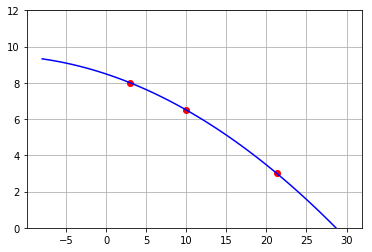

In [0]:
coeffs=np.polyfit(df.X,df.Y,deg=2)

P=np.poly1d(coeffs)
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

print(np.poly1d(coeffs))

In [0]:
print(np.poly1d(coeffs))

 
5.5


## Derivation

Let's suppose a well-behaved yet unknown function $f$ and two points $(x_0,y_0)$ and $(x_1,y_1)$ for which $f(x_0) = y_0$ and $f(x_1) = y_1$. With this information we can build a first-degree polynomial that passes through both points by using the last equation in sec. [Linear Interpolation](interpolation.ipynb#Linear-Interpolation), we have

$$P_1(x) = \left[ \frac{y_{1}-y_0}{x_{1}-x_0} \right]x + \left[ y_0 - \frac{y_{1}-y_0}{x_{1}-x_0}x_0 \right]$$

We can readily rewrite this expression like:

$$P_1(x) = L_0(x)f(x_0) + L_1(x)f(x_1)$$

where we define the functions $L_0(x)$ and $L_1(x)$ as:

$$L_0(x) = \frac{x-x_1}{x_0-x_1} \mbox{ and } L_1(x) = \frac{x-x_0}{x_1-x_0}$$

Note then that

$$L_0(x_0) = 1,\ \ \ L_0(x_1) = 0,\ \ \ L_1(x_0) = 0,\ \ \ L_1(x_1) = 1$$

implying:

$$P_1(x_0) = f(x_0) = y_0$$

$$P_1(x_1) = f(x_1) = y_1$$

Although all this procedure may seem unnecessary for a line, a generalization to larger datasets is direct.

## General case
Let's assume again a well-behaved and unknown function $f$ sampled by using a set of $n+1$ data $(x_m,y_m)$ ($0\leq m \leq n$).
We call the set of $[x_0,x_1,\ldots,x_n]$ as the _node_ points of the _interpolation polynomial in the Lagrange form_, $P_n(x)$, where:
$$f(x)\approx P_n(x)\,,$$

$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x) = \sum_{i=0}^n y_iL_{n,i}(x)$$

We need to find the _Lagrange polynomials_,  $L_{n,i}(x)$, such that 
$$L_{n,i}(x_i) = 1\,,\qquad\text{and}\,,\qquad L_{n,i}(x_j) = 0\quad\text{for $i\neq j$}$$ 
A function that satisfies this criterion is

$$L_{n,i}(x) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x-x_m}{x_i-x_m} =\frac{(x-x_0)}{(x_i-x_0)}\frac{(x-x_1)}{(x_i-x_1)}\cdots \frac{(x-x_{i-1})}{(x_i-x_{i-1})}\underbrace{\frac{}{}}_{m\ne i}
\frac{(x-x_{i+1})}{(x_i-x_{i+1})} \cdots \frac{(x-x_{n-1})}{(x_i-x_{n-1})}\frac{(x-x_n)}{(x_i-x_n)}  $$
Please note that in the expansion the term $(x-x_i)$ does not appears in both the numerator and the denominator as stablished in the productory condition $m\neq i$.

Moreower
$$L_{n,i}(x_i) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x_i-x_m}{x_i-x_m} =1$$
and, for $j\ne i$
$$L_{n,i}(x_j) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x_j-x_m}{x_i-x_m} =\frac{(x_j-x_0)}{(x_i-x_0)}\cdots \frac{(\boldsymbol{x_j}-\boldsymbol{x_j})}{(x_i-x_j)}\cdots\frac{(x_j-x_n)}{(x_i-x_n)}=0.$$


Then, the polynomial of $n$th-degree $P_n(x)$ will satisfy the definitory property for a interpolating polynomial, i.e. $P_n(x_i) = y_i$ for any $i$ and it is called the _interpolation Polynomial in the Lagrange form_.

Check [this implementation in sympy](./LagrangePoly.ipynb) wehre both the interpolating polynomial and the Lagrange polynomials are defined.

**Further details at:**
[Wikipedia](https://en.wikipedia.org/wiki/Lagrange_polynomial)

### Example:
Obtain the Lagrange Polynomials for a Interpolation polynomial of degree 1.

$i=0$, $n=1$
$$ L_{2,0}=\prod_{\begin{smallmatrix}m=0\\ m\neq 0\end{smallmatrix}}^1 \frac{x-x_m}{x_i-x_m}=\prod_{\begin{smallmatrix}m=1\end{smallmatrix}}^1 \frac{x-x_m}{x_0-x_m}=\frac{x-x_1}{x_0-x_1}$$
$i=i$, $n=1$
$$ L_{2,1}=\prod_{\begin{smallmatrix}m=0\\ m\neq 1\end{smallmatrix}}^1 \frac{x-x_m}{x_i-x_m}=\prod_{\begin{smallmatrix}m=0\end{smallmatrix}}^0 \frac{x-x_m}{x_1-x_m}=\frac{x-x_0}{x_1-x_0}$$

### Exercise-interpolation
Obtain the Lagrange Polynomials for a Interpolation polynomial of degree 2.

### Implementation in Scipy

In [0]:
from scipy import interpolate

In [0]:
interpolate.lagrange?

In [0]:
P=interpolate.lagrange(df.X,df.Y)
print(P)

           2
-0.005216 x - 0.1465 x + 8.486


(0, 12)

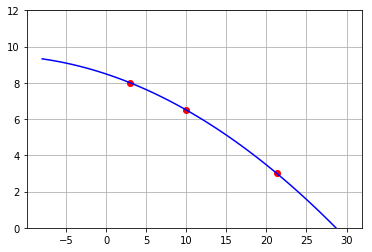

In [0]:
plt.plot(df.X,df.Y,'ro')
x=np.linspace(-8,30)
plt.plot(x,P( x),'b-')
plt.grid()
plt.ylim(0,12)

### Implementation in `sympy`
For details see [here](./LagrangePoly.ipynb)

In [0]:
import LagrangePolynomial as LP
LP.lagrangePolynomial(df.X,df.Y)

-0.00521578136549849*x**2 - 0.146480556534234*x + 8.48638370189219

$$P_n(x) =  \sum_{i=0}^n L_{n,i}(x) \, y_i$$

In [0]:
LP.polyL( df.X,0)*df.Y[0]+LP.polyL( df.X,1)*df.Y[1]+LP.polyL( df.X,2)*df.Y[2]

0.0559573894841558*x**2 - 1.44173177757974*x + 11.8215788273818

## Steps LP

Once defined the formal procedure for constructing a Lagrange Polynomial, we proceed to describe the explicit algorithm:

1. Give the working dataset $(x_i, y_i)$ and stablish how many points you have.
2. Define the functions $L_{n,i}(x)$ in a general way.
3. Add each of those terms as shown in last expression.
4. Evaluate your result wherever you want.

## <font color='red'>     **Activity** </font>

<font color='red'>    
    
Along with the professor, write an implementation of the previous algorithm during classtime.
</font>

## Activity LP

<div style="float: right;" markdown="1">
    <img src="http://universe-review.ca/I05-28-NGC7331.jpg">
</div>

One of the very first evidences of the existence of dark matter was the flat rotation curves of spiral galaxies. If we assume the total budget of mass of a galaxy is entirely made of luminous matter, the orbital circular velocity of stars around the galaxy plane should decay according to a keplerian potential. However this is not the case and the circular velocity barely decreases at larger radius, thus indicating the presence of a new non-visible matter component (dark matter). When it is necessary to determine how massive is the dark matter halo embedding a galaxy, an integration of the circular velocity is required. Nevertheless, due to the finite array of a CCD camera, only a discrete set of velocities can be measured and interpolation techniques are required.


In this activity we will take a discrete dataset of the circular velocity as a function of the radius for the galaxy [NGC 7331](http://es.wikipedia.org/wiki/NGC_7331) and perform both, a linear and a Lagrange interpolation. You can download the dataset from this [link](https://raw.githubusercontent.com/sbustamante/ComputationalMethods/master/data/NGC7331.dat).


[Video](https://upload.wikimedia.org/wikipedia/commons/transcoded/3/33/Galaxy_rotation_under_the_influence_of_dark_matter.ogv/Galaxy_rotation_under_the_influence_of_dark_matter.ogv.360p.webm)

<font color='blue'>
**TRIVIA**<br/> 
To which of two curves the real data approach better?
</font>

import os
os.remove('trivia_results.txt')

In [0]:
f=open('trivia_results.txt','a')
AB=input(r'''A: to the curve "velocity goes to zero when distance goes to infinity"
B: to the curve "velocity goes to high constant when distance goes to infinity"
''')
f.write( '{}\n'.format(AB) )
f.close()

A: to the curve "velocity goes to zero when distance goes to infinity"
B: to the curve "velocity goes to high constant when distance goes to infinity"
C


In [0]:
fr=open('trivia_results.txt')
print( fr.read())
fr.close()

C



os.remove('trivia_results.txt')

### Lets us check! 

In [0]:
#DATA URL: 
url='https://raw.githubusercontent.com/sbustamante/ComputationalMethods/master/data/NGC7331.dat'
df=pd.read_table(url,sep='\s+',header=None)
df[0:5]

,0,1
0,0.05,33.42496
1,0.10,71.70398
2,0.15,95.14708
3,0.20,107.32276
4,0.25,117.44285


To rename columns of a DataFrame
```python
df.rename_axis({'OLD':'NEW'}, axis = 'columns')
```
Further tips and tricks with Pandas: [here](https://github.com/restrepo/PythonTipsAndTricks)

In [0]:
df=df.rename_axis({0:'r'}, axis = 'columns')
df=df.rename_axis({1:'v'}, axis = 'columns')
df[0:5]

,r,v
0,0.05,33.42496
1,0.10,71.70398
2,0.15,95.14708
3,0.20,107.32276
4,0.25,117.44285


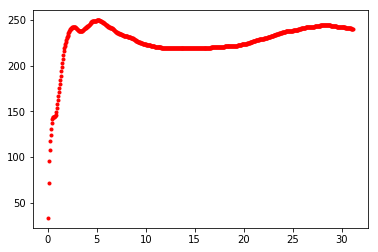

In [0]:
plt.plot(df.r,df.v,'r.')

Build expected data

In [0]:
dff=df[:60]
#dff=dff.append(pd.DataFrame( {'r':[5,10],'v':[60,20]} )).reset_index(drop=True) # ,15,20,25,30 ,120,105,100,98
#dff=dff.append(pd.DataFrame( {'r':[3.5,4,10],'v':[230,200,20]} )).reset_index(drop=True) # ,15,20,25,30 ,120,105,100,98
dff=dff.append(pd.DataFrame( {'r':[3.5,4,9],'v':[230,200,22]} )).reset_index(drop=True) # ,15,20,25,30 ,120,105,100,98

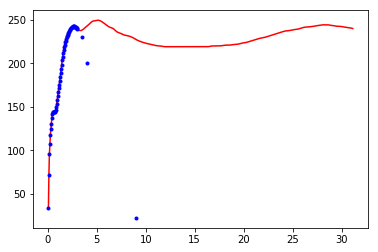

In [0]:
plt.plot(df['r'],df['v'],'r-')
plt.plot(dff.r, dff.v,'b.')

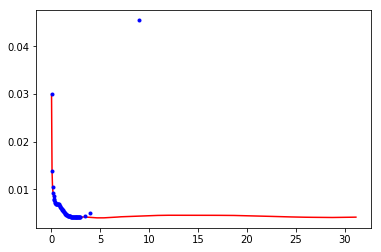

In [0]:
plt.plot(df['r'],1./df['v'],'r-')
plt.plot(dff['r'],1./dff['v'],'b.')

In [0]:
coeff=np.polyfit(dff['r'],1./dff['v'],2)
P=poly1d(coeff,variable='r')
print(P)

          2
0.001084 r - 0.00594 r + 0.01169


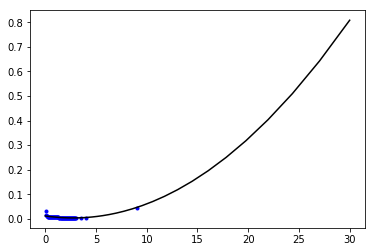

In [0]:
r=np.logspace( np.log10(0.001),np.log10(30 ),100 )
plt.plot(dff['r'],1./dff['v'],'b.')
plt.plot(r,P(r),'k-')

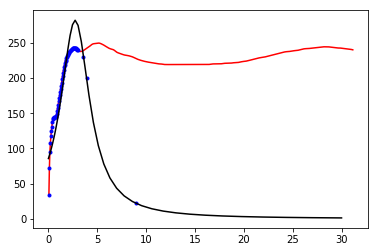

In [0]:
plt.plot(df['r'],df['v'],'r-')
plt.plot(dff['r'],dff['v'],'b.')
plt.plot(r,1/P(r),'k-')

- - -

# Appendix
Thecnical details of interpolation functions: [interpolation_details.ipynb](./interpolation_details.ipynb)